In [1]:
# Code to plot zonal average SSTs for CMIP6 ensemble + observational data
# Author: Nathan Erickson
# Date: 3/20/2022
# Coded with Python 3.8.10

In [2]:
# Import necessary modules

import os
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import pandas as pd
import xarray as xr
import numpy as np
import warnings
from datetime import datetime

#from cmip6_processing import zonal_avg_ens_calculator

In [3]:
# Set base directory, open data file

data_dir = '/chinook2/nathane1/Thesis/'
home_dir = '/home/nathane1/Thesis/'
os.chdir(data_dir)
obs_ssts = xr.open_dataset('sst.mnmean.nc')

In [4]:
obs_ssts

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2012, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2021-08-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2021-09-07

In [5]:
model_list = ["ACCESS-CM2", "ACCESS-ESM1-5", "AWI-CM-1-1-MR", "BCC-CSM2-MR", "CAMS-CSM1-0", "CanESM5", "CESM2", "CESM2-WACCM", "CMCC-CM2-SR5", 
              "CNRM-CM6-1", "CNRM-CM6-1-HR", "CNRM-ESM2-1", "EC-Earth3", "EC-Earth3-Veg", "FGOALS-f3-L", "GFDL-CM4", "GFDL-ESM4", 
              "GISS-E2-1-G", "HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "INM-CM4-8", "INM-CM5-0", "IPSL-CM6A-LR", "MIROC-ES2L",
              "MPI-ESM1-2-HR", "MPI-ESM1-2-LR", "MRI-ESM2-0", "NESM3", "NorESM2-LM", "NorESM2-MM", "TaiESM1"]
ens_size = range(len(model_list))

In [6]:
# Define function for getting longitudinal average SST change over time
def zonal_diff_ens_calculator(model, time_option, period, lon_bounds, lat_bounds):
    # Get model simulations, combine them into one variable
    model_run = model_list[model]
    model_dir = data_dir + 'CMIP6/' + model_run
    os.chdir(model_dir)
    model_filename = f'ts_Amon_{model_run}*.nc'
    model_file = glob.glob(model_filename)
    model_ssts = [xr.open_dataset(f'{model_dir}/{model_file[file]}') for file in range(len(model_file))]
    # Get land mask
    os.chdir(model_dir)
    mask_filename = f'sftlf_fx_{model_run}*.nc'
    mask_file = glob.glob(mask_filename)
    land_mask = xr.open_dataset(mask_file[0])
    # Time formatting options
    sims = range(len(model_file))
    if model_ssts[0]['time'].dtype != '<M8[ns]': # <M8[ns] = datetime data type
        for sim in sims:
            model_ssts[sim]['time'] = model_ssts[sim].indexes['time'].to_datetimeindex()
            #print(model_ssts[sim]['time'])
    if 'EC-Earth3' in model_run:
        for sim in sims:
            model_ssts[sim] = model_ssts[sim].sel(time = slice('1850-01-16T12:00:00.000000000','2100-12-16T12:00:00.000000000'), lat = slice(5,-5))
    # Get averages across all simulations for model
    for sim in sims:
        if 'model_sims' in locals():
            model_sims += model_ssts[sim].ts
        else:
            model_sims = model_ssts[0].ts
    model_avg = model_sims / len(sims)
     # Perform data subsetting if desired
    if time_option == ('djf' or 'DJF'):
        model_avg = model_avg.loc[[(np.datetime_as_string(model_avg['time'].values)[time][5:7]  == '01') or
              (np.datetime_as_string(model_avg['time'].values)[time][5:7]  == '02') or
              (np.datetime_as_string(model_avg['time'].values)[time][5:7]  == '12') for time in range(len(model_avg['time'].values))]]
    else:
        pass
    if period == ('hist+future'):
        historical_ssts = model_avg.loc[dict(time=slice('1851-01-01','1900-12-01'))]
        future_ssts = model_avg.loc[dict(time=slice('2051-01-01','2100-12-01'))]
    else:
        pass
    # Interpolate to common grid
    interp_hist = historical_ssts.interp_like(obs_ssts.sst)
    interp_future = future_ssts.interp_like(obs_ssts.lon).interp_like(obs_ssts.lat)
    # Convert SSTs to Kelvin
    conv_hist = interp_hist - 273.15
    conv_future = interp_future - 273.15
    # Average over latitude and time
    hist_tropics = conv_hist.sel(lat=slice(lat_bounds[0],lat_bounds[1]), lon=slice(lon_bounds[0],lon_bounds[1]))
    hist_avg = hist_tropics.groupby("time").mean("lat")
    zonal_hist_avg = hist_avg.groupby("lon").mean("time")
    
    future_tropics = conv_future.sel(lat=slice(lat_bounds[0],lat_bounds[1]), lon=slice(lon_bounds[0],lon_bounds[1]))
    future_avg = future_tropics.groupby("time").mean("lat")
    zonal_future_avg = future_avg.groupby("lon").mean("time")
    # Send to temp. dataset, clear initial dataset
    dummy_1 = zonal_hist_avg
    dummy_1 = dummy_1.to_dataset()
    
    dummy_2 = zonal_future_avg
    dummy_2 = dummy_2.to_dataset()
    if 'temp_dataset' not in locals():
        temp_dataset_hist = dummy_1.rename_vars({'ts':f'{model_run}-ts'})
    else:
        temp_dataset_hist = xr.merge([temp_dataset_hist,dummy_1.ts])
        temp_dataset_hist = temp_dataset_hist.rename_vars({'ts':f'{model_run}-ts'})
    if 'temp_dataset1' not in locals():
        temp_dataset_fut = dummy_2.rename_vars({'ts':f'{model_run}-ts'})
    else:
        temp_dataset_fut = xr.merge([temp_dataset_fut,dummy_2.ts])
        temp_dataset_fut = temp_dataset_fut.rename_vars({'ts':f'{model_run}-ts'})
    # Save results to outfile
    os.chdir(data_dir)
    out_files = ['hist_zonal_averages.nc','future_zonal_averages.nc']      
    if os.path.isfile(out_files[0]) == True: #This code right here sucks, generalize this
        temp_dataset_hist.to_netcdf(out_files[0],mode='a')
        temp_dataset_fut.to_netcdf(out_files[1],mode='a')
    else:
        temp_dataset_hist.to_netcdf(out_files[0],mode='w')
        temp_dataset_fut.to_netcdf(out_files[1],mode='w')
    del model_ssts, model_sims, land_mask, model_avg, historical_ssts, future_ssts 
    del interp_hist, interp_future, conv_hist, conv_future, hist_tropics, hist_avg, zonal_hist_avg
    del future_tropics, future_avg, zonal_future_avg, dummy_1, dummy_2, out_files
    return model_run,temp_dataset_hist,temp_dataset_fut

In [7]:
for model in ens_size:
    try:
        model_name,hist_data,fut_data = zonal_diff_ens_calculator(model,'djf','hist+future',[160,270],[5,-5])
        print(f'Successfully computed zonal averages for {model_name}!')
    except (ValueError):
    #except (ValueError,InvalidIndexError):
        continue

<xarray.DataArray 'ts' (time: 149, lat: 144, lon: 192)>
array([[[252.9471 , 252.9218 , 252.90569, ..., 253.13281, 253.13501,
         253.10164],
        [252.49487, 252.44905, 252.40056, ..., 252.56201, 252.54167,
         252.50537],
        [252.86458, 252.76262, 252.70573, ..., 253.09685, 252.98975,
         252.88884],
        ...,
        [238.98853, 239.03947, 239.09929, ..., 238.75725, 238.81975,
         238.93066],
        [238.67781, 238.7107 , 238.7718 , ..., 238.57088, 238.5909 ,
         238.62688],
        [237.99812, 237.99724, 238.03133, ..., 237.92293, 237.96443,
         237.94873]],

       [[236.38647, 236.31013, 236.26399, ..., 236.22005, 236.3116 ,
         236.49886],
        [235.36565, 235.37785, 235.40315, ..., 235.8033 , 235.75749,
         235.5467 ],
        [235.9152 , 235.77344, 235.60945, ..., 236.56184, 236.3178 ,
         236.05525],
...
        [235.16455, 235.10603, 235.10579, ..., 235.19441, 235.1722 ,
         235.1473 ],
        [234.7426 , 234.7

RuntimeError: Want to stop here

In [12]:
hist_zonal_averages = xr.open_dataset(os.path.join(data_dir + 'hist_zonal_averages.nc'))
future_zonal_averages = xr.open_dataset('/chinook2/nathane1/Thesis/future_zonal_averages.nc')
#hist_zonal_averages

In [8]:
zonal_avg_change = future_zonal_averages - hist_zonal_averages
zonal_avg_change

NameError: name 'future_zonal_averages' is not defined

In [67]:
hist_zonal_averages['ACCESS-CM2-ts'] + hist_zonal_averages['ACCESS-ESM1-5-ts']

<xarray.DataArray (lon: 56)>
array([57.38931617, 57.22924272, 57.0608057 , 56.88220302, 56.7049136 ,
       56.52467285, 56.34699046, 56.16909752, 55.97239181, 55.76657351,
       55.56105858, 55.36372428, 55.17058571, 54.97721139, 54.78798374,
       54.60448111, 54.42504027, 54.24537641, 54.0663528 , 53.89429722,
       53.71880999, 53.54628521, 53.38143917, 53.21900661, 53.05322129,
       52.89326369, 52.74429388, 52.59921771, 52.46413261, 52.34321046,
       52.22646339, 52.11841678, 52.01238476, 51.90968631, 51.82498732,
       51.74745454, 51.67011284, 51.60459776, 51.55736581, 51.52114225,
       51.48276156, 51.45012572, 51.43053912, 51.42111163, 51.43250976,
       51.47190132, 51.54567329, 51.65177883, 51.79360259, 51.97211155,
       52.19811144, 52.48279772, 52.83077127, 53.22377868, 53.63817392,
       54.03986401])
Coordinates:
  * lon      (lon) float64 160.0 162.0 164.0 166.0 ... 264.0 266.0 268.0 270.0

Text(0.5, 1.0, 'Zonal SST Change from Historical to Future Climate - Niño 3+4 Region')

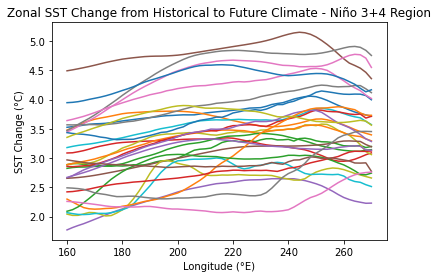

In [62]:
zonal_fig, zonal_ax = plt.subplots()
for var in zonal_avg_change.data_vars:
    zonal_ax.plot(zonal_avg_change[var])
#zonal_ax.plot(zonal_avg_change.sst)

l1 = mpatches.Patch(color='r', label='Model SSTs')
#l2 = mpatches.Patch(color='b', label='Observed SSTs')
#plt.legend(handles=[l1])
#zonal_ax.set_xticklabels([150,170,190,210,230,250,270])
x_pos = np.arange(len(zonal_avg_change.lon), step = 10)
x_interval = int(np.round(len(zonal_avg_change.lon)/len(x_pos))) + 1 
zonal_ax.set_xticks(x_pos, labels = zonal_avg_change.lon[::x_interval].astype(int).values)
zonal_ax.set_xlabel('Longitude (°E)')
zonal_ax.set_ylabel('SST Change (°C)')
zonal_ax.set_title('Zonal SST Change from Historical to Future Climate - Niño 3+4 Region')

In [60]:
img_dir = '/home/nathane1/Thesis/images'
os.chdir(img_dir)

zonal_diff_fig = zonal_ax.get_figure()
zonal_diff_fig.savefig('zonal_average_differences_3+4.jpg',bbox_inches = 'tight')

In [12]:
#zonal_avg = hist_obs_tropics.groupby("time").mean("lat")
#zonal_period_avg = zonal_avg.groupby("lon").mean("time")
#zonal_period_avg

In [13]:
zonal_period_avg_plot = zonal_period_avg.sst.plot(x="lon")

NameError: name 'zonal_period_avg' is not defined

In [ ]:
zonal_fig, zonal_ax = plt.subplots()
for var in ens_zonal_averages.data_vars:
    zonal_ax.plot(ens_zonal_averages[var],color = 'r')
zonal_ax.plot(zonal_period_avg.sst)

l1 = mpatches.Patch(color='r', label='Model SSTs')
l2 = mpatches.Patch(color='b', label='Observed SSTs')
plt.legend(handles=[l1, l2])
zonal_ax.set_xticklabels([150,170,190,210,230,250,270])
zonal_ax.set_xlabel('Longitude (°E)')
zonal_ax.set_ylabel('SST (°C)')
zonal_ax.set_title('Zonal SST Distributions for Contemporary Climate')

In [ ]:
os.chdir(img_dir)
zonal_img = zonal_fig.get_figure()
#zonal_img.savefig('djf_zonal_avg.jpg', bbox_inches = 'tight')